# Preprocessing MEA Data

This notebook preprocesses the MEA data by extracting files, transforming data into a 3D array, and visualizing the data.


In [219]:
# Extracting and Processing Data
import os
import glob
import zipfile
import time
import numpy as np
from tqdm import tqdm
from scipy.signal import find_peaks
import h5py
import numpy as np
from scipy.io import loadmat
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from scipy.signal import butter, filtfilt, welch, find_peaks
import networkx as nx
import umap

# Project-specific imports 
import sys
sys.path.append("C:\\Users\\golan\\Desktop\\pythonProject\\2024\\venv\\lib\\site-packages")
import McsPy

import McsPy.McsData
import McsPy.McsCMOS

# Data Visualization
import matplotlib.pyplot as plt

# Data Preparation for ML
import pandas as pd
from sklearn.model_selection import train_test_split

# Building and ML learnning Models
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, roc_curve, auc 

# Additional Utilities
from collections import Counter


In [12]:
# Helper functions
def get_ch_from_id(id):
    return [key for key, value in channels_dict.items() if value == id][0] - 1


In [13]:
def extract_zip_files(from_folder=".", to_folder="./MEA recordings"):
    from_folder = os.path.join(from_folder, "*.zip")
    files = glob.glob(from_folder)
    
    for file in files:
        with zipfile.ZipFile(file, 'r') as zip_ref:
            # Extract each file individually
            for member in zip_ref.namelist():
                # Flatten the directory structure
                filename = os.path.basename(member)
                if filename:  # Avoid directories
                    destination = os.path.join(to_folder, filename)
                    # Ensure destination folder exists
                    os.makedirs(os.path.dirname(destination), exist_ok=True)
                    with zip_ref.open(member) as source_file, open(destination, "wb") as output_file:
                        output_file.write(source_file.read())

    print(f"Extracted {len(files)} zip files to {to_folder} folder")

In [25]:
def extract_data_from_all_files(from_folder='./"MEA recordings"', to_folder=r'output'):
    h5files = glob.glob("./MEA recordings/*.h5")
    i = 0
    for file in tqdm(h5files):
        transform_data_to_3d_array(file, i)
        i += 1

# In MEA the channels arrange by:

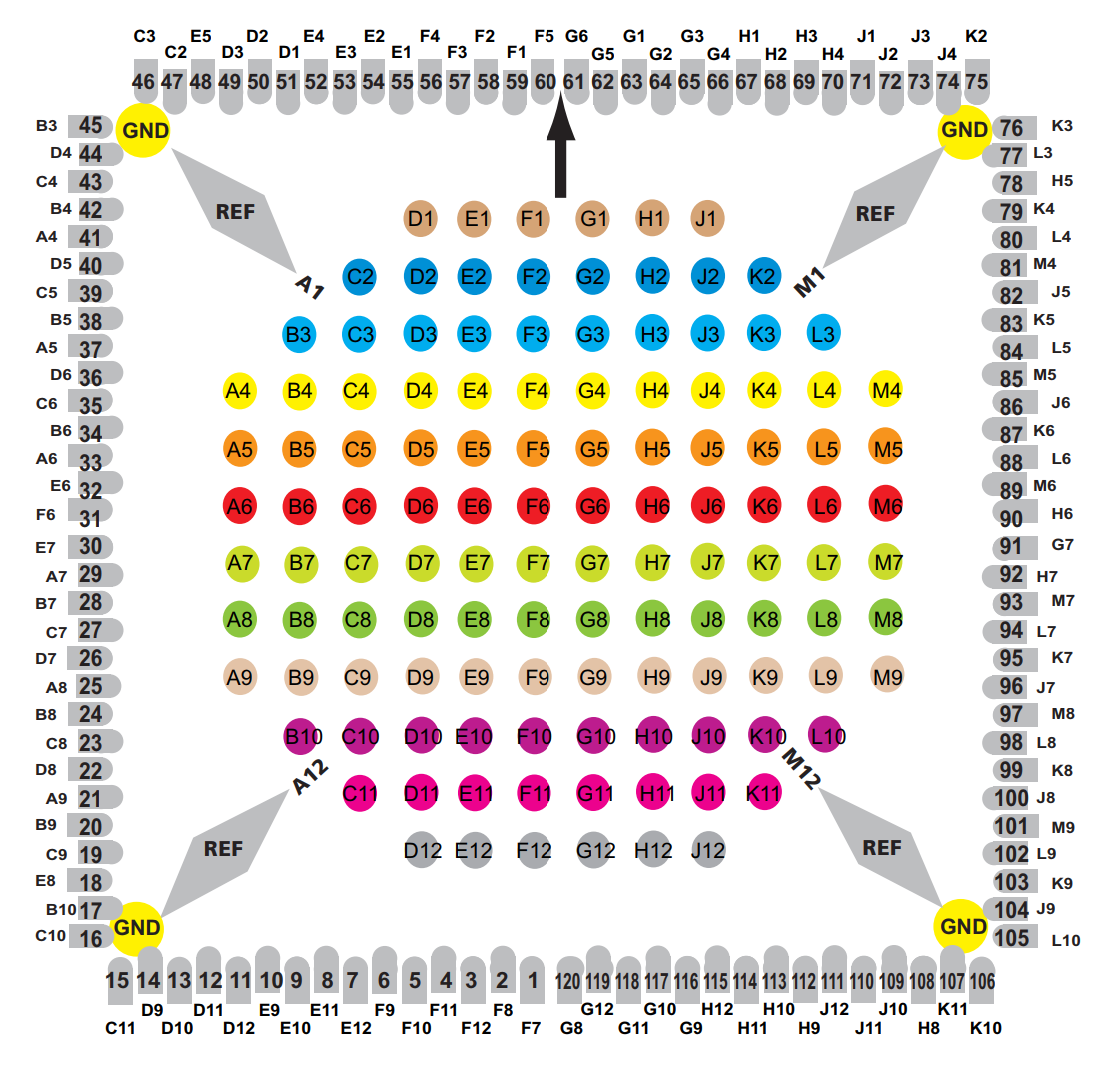

### So we are creating a 12*12 2d matching array (ids)
in light yellow are the cells which exist only in the array
<table border="1">
  <tr>
    <td style="background-color: lightyellow;">A1</td>
    <td style="background-color: lightyellow;">B1</td>
    <td style="background-color: lightyellow;">C1</td>
    <td>D1</td>
    <td>E1</td>
    <td>F1</td>
    <td>G1</td>
    <td>H1</td>
    <td>J1</td>
    <td style="background-color: lightyellow;">K1</td>
    <td style="background-color: lightyellow;">L1</td>
    <td style="background-color: lightyellow;">M1</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A2</td>
    <td style="background-color: lightyellow;">B2</td>
    <td>C2</td>
    <td>D2</td>
    <td>E2</td>
    <td>F2</td>
    <td>G2</td>
    <td>H2</td>
    <td>J2</td>
    <td>K2</td>
    <td style="background-color: lightyellow;">L2</td>
    <td style="background-color: lightyellow;">M2</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A3</td>
    <td>B3</td>
    <td>C3</td>
    <td>D3</td>
    <td>E3</td>
    <td>F3</td>
    <td>G3</td>
    <td>H3</td>
    <td>J3</td>
    <td>K3</td>
    <td>L3</td>
    <td style="background-color: lightyellow;">M3</td>
  </tr>
  <tr>
    <td>A4</td>
    <td>B4</td>
    <td>C4</td>
    <td>D4</td>
    <td>E4</td>
    <td>F4</td>
    <td>G4</td>
    <td>H4</td>
    <td>J4</td>
    <td>K4</td>
    <td>L4</td>
    <td>M4</td>
  </tr>
  <tr>
    <td>A5</td>
    <td>B5</td>
    <td>C5</td>
    <td>D5</td>
    <td>E5</td>
    <td>F5</td>
    <td>G5</td>
    <td>H5</td>
    <td>J5</td>
    <td>K5</td>
    <td>L5</td>
    <td>M5</td>
  </tr>
  <tr>
    <td>A6</td>
    <td>B6</td>
    <td>C6</td>
    <td>D6</td>
    <td>E6</td>
    <td>F6</td>
    <td>G6</td>
    <td>H6</td>
    <td>J6</td>
    <td>K6</td>
    <td>L6</td>
    <td>M6</td>
  </tr>
  <tr>
    <td>A7</td>
    <td>B7</td>
    <td>C7</td>
    <td>D7</td>
    <td>E7</td>
    <td>F7</td>
    <td>G7</td>
    <td>H7</td>
    <td>J7</td>
    <td>K7</td>
    <td>L7</td>
    <td>M7</td>
  </tr>
  <tr>
    <td>A8</td>
    <td>B8</td>
    <td>C8</td>
    <td>D8</td>
    <td>E8</td>
    <td>F8</td>
    <td>G8</td>
    <td>H8</td>
    <td>J8</td>
    <td>K8</td>
    <td>L8</td>
    <td>M8</td>
  </tr>
  <tr>
    <td>A9</td>
    <td>B9</td>
    <td>C9</td>
    <td>D9</td>
    <td>E9</td>
    <td>F9</td>
    <td>G9</td>
    <td>H9</td>
    <td>J9</td>
    <td>K9</td>
    <td>L9</td>
    <td>M9</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A10</td>
    <td>B10</td>
    <td>C10</td>
    <td>D10</td>
    <td>E10</td>
    <td>F10</td>
    <td>G10</td>
    <td>H10</td>
    <td>J10</td>
    <td>K10</td>
    <td>L10</td>
    <td style="background-color: lightyellow;">M10</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A11</td>
    <td style="background-color: lightyellow;">B11</td>
    <td>C11</td>
    <td>D11</td>
    <td>E11</td>
    <td>F11</td>
    <td>G11</td>
    <td>H11</td>
    <td>J11</td>
    <td>K11</td>
    <td style="background-color: lightyellow;">L11</td>
    <td style="background-color: lightyellow;">M11</td>
  </tr>
  <tr>
    <td style="background-color: lightyellow;">A12</td>
    <td style="background-color: lightyellow;">B12</td>
    <td style="background-color: lightyellow;">C12</td>
    <td>D12</td>
    <td>E12</td>
    <td>F12</td>
    <td>G12</td>
    <td>H12</td>
    <td>J12</td>
    <td style="background-color: lightyellow;">K12</td>
    <td style="background-color: lightyellow;">L12</td>
    <td style="background-color: lightyellow;">M12</td>
  </tr>
</table>




In [22]:
def clean_noise(channel_data, sampling_frequency):
    # Calculate the threshold
    threshold = np.median(np.abs(channel_data) / 0.6745) * 5

    # Calculate the number of samples corresponding to 1 millisecond
    npulse = int(1e-3 * sampling_frequency)
    window = npulse * 3  # 3 millisecond window

    # Find positive peaks above the threshold
    positive_peaks, positive_properties = find_peaks(channel_data, height=threshold, distance=1)

    # Find negative peaks below the negative threshold (equivalent to -threshold)
    negative_peaks, negative_properties = find_peaks(-channel_data, height=threshold, distance=1)

    # Combine both sets of peaks and their heights
    all_peaks = np.concatenate((positive_peaks, negative_peaks))
    all_heights = np.concatenate((positive_properties['peak_heights'], negative_properties['peak_heights']))

    # Sort peaks by position
    sorted_indices = np.argsort(all_peaks)
    all_peaks = all_peaks[sorted_indices]
    all_heights = all_heights[sorted_indices]

    # Initialize list to store filtered peaks
    filtered_peaks = []

    # Compare each peak with its neighbors within the 3 ms window
    i = 0
    while i < len(all_peaks):
        # Initialize a new peak group
        peak_group = [all_peaks[i]]
        height_group = [all_heights[i]]
        
        # Initialize j to i in case the inner loop is not executed
        j = i  

        # Check peaks in the next 3 ms window (75 samples)
        for j in range(i + 1, len(all_peaks)):
            if all_peaks[j] - all_peaks[i] > window:
                break
            peak_group.append(all_peaks[j])
            height_group.append(all_heights[j])

        # Retain the peak with the maximum absolute value within the group
        best_peak_index = np.argmax(np.abs(height_group))
        best_peak = peak_group[best_peak_index]
        filtered_peaks.append(best_peak)

        # Now, move the window based on the best peak
        i = j  # Move 'i' to the next peak outside the current window

        # Skip peaks within 75 samples of the best peak
        while i < len(all_peaks) and all_peaks[i] - best_peak <= window:
            i += 1

    # Create a mask to retain samples 0.6 ms before and 1.4 ms after each filtered peak
    mask = np.zeros_like(channel_data, dtype=bool)
    for peak in filtered_peaks:
        start = int(max(0, peak - (0.6 * npulse)))  # 0.6 ms before the peak
        end = int(min(len(channel_data), peak + (1.4 * npulse)))  # 1.4 ms after the peak
        mask[start:end + 1] = True

    # Apply the mask to the data
    return np.where(mask, channel_data, 0)

In [21]:
def transform_data_to_3d_array(file_name, folder_path = r'output'):
    channel_raw_data = McsPy.McsData.RawData(file_name)
    recording = channel_raw_data.recordings[0]
    try:  # Try to get the analog stream, most of the time it will be the in place 3 but sometimes it will be 0
        analog_stream = recording.analog_streams[3]
    except KeyError:
        try:
            analog_stream = recording.analog_streams[0]
        except KeyError:
            print("Error: No analog stream found in the file " + file_name + " Skipping...")
            return
#     start_time = time.time()
    samples = analog_stream.channel_data.shape[1]
    array_3d = np.zeros((12, 12, samples), dtype=float)
    ids = np.empty((12, 12), dtype=object)

    for i in range(12):
        for j in range(12):
            # Convert number to uppercase character (A-H) or 'J' for index 8
            ids[i, j] = chr(j + 65) + str(i + 1) if j < 8 else chr(j + 66) + str(i + 1)

    # Create a boolean mask to check if IDs are in channels_dict.values()
    mask = np.isin(ids, list(channels_dict.values()))

    # Get the indices where the mask is True
    indices = np.where(mask)

    count = 0
#     Get samples from analog_stream for the indices where mask is True, 1e6 is to convert from V to uV
    for idx, (i, j) in enumerate(zip(*indices)):
        channel_data = analog_stream.get_channel(get_ch_from_id(ids[i, j]))[0] * 1e6
        # clean noise
        sampling_frequency = round(analog_stream.channel_infos[0].sampling_frequency.magnitude)  # Hz
        channel_data = clean_noise(channel_data, sampling_frequency)
        array_3d[i, j] = channel_data
        count += 1
        if count % 10 == 0:
            print(f"Processed {count} channels out of {len(indices[0])}")

    sampling_frequency = int(sampling_frequency / 1000)  # kHz
    # Save the 3D array to a file in the output folder
    folder_path = r'output'
    if 'control' in file_name or 'w_oMNPs' in file_name:
        folder_path = fr'output\w_oMNPs\{sampling_frequency}'
    if 'withMNPs' in file_name:
        folder_path = fr'output\withMNPs\{sampling_frequency}'
    file_name = file_name.split('/')[-1].split('.')[0]
    cleaned_name = file_name[file_name.find('\\') + 1:]
    cleaned_name = cleaned_name.replace('\\', '.')
    fn = os.path.join(folder_path, str("data_" + cleaned_name + ".npy"))
    np.save(fn, array_3d)
    print(f"saving file {cleaned_name} to {folder_path}")


In [17]:
channels_dict = {120: "G8", 119: "G12", 118: "G11", 117: "G10", 116: "G9", 115: "H12", 114: "H11", 113: "H10",
                 112: "H9", 111: "J12", 110: "J11", 109: "J10", 108: "H8", 107: "K11", 106: "K10", 105: "L10",
                 104: "J9", 103: "K9", 102: "L9", 101: "M9", 100: "J8", 99: "K8", 98: "L8", 97: "M8", 96: "J7",
                 95: "K7", 94: "L7", 93: "M7", 92: "H7", 91: "G7", 90: "H6", 89: "M6", 88: "L6", 87: "K6", 86: "J6",
                 85: "M5", 84: "L5", 83: "K5", 82: "J5", 81: "M4", 80: "L4", 79: "K4", 78: "H5", 77: "L3", 76: "K3",
                 75: "K2", 74: "J4", 73: "J3", 72: "J2", 71: "J1", 70: "H4", 69: "H3", 68: "H2", 67: "H1", 66: "G4",
                 65: "G3", 64: "G2", 63: "G1", 62: "G5", 61: "G6", 60: "F5", 59: "F1", 58: "F2", 57: "F3", 56: "F4",
                 55: "E1", 54: "E2", 53: "E3", 52: "E4", 51: "D1", 50: "D2", 49: "D3", 48: "E5", 47: "C2", 46: "C3",
                 45: "B3", 44: "D4", 43: "C4", 42: "B4", 41: "A4", 40: "D5", 39: "C5", 38: "B5", 37: "A5", 36: "D6",
                 35: "C6", 34: "B6", 33: "A6", 32: "E6", 31: "F6", 30: "E7", 29: "A7", 28: "B7", 27: "C7", 26: "D7",
                 25: "A8", 24: "B8", 23: "C8", 22: "D8", 21: "A9", 20: "B9", 19: "C9", 18: "E8", 17: "B10", 16: "C10",
                 15: "C11", 14: "D9", 13: "D10", 12: "D11", 11: "D12", 10: "E9", 9: "E10", 8: "E11", 7: "E12", 6: "F9",
                 5: "F10", 4: "F11", 3: "F12", 2: "F8", 1: "F7"}

## Extract data

step 1 - extract the h5 files from all zip files to the MEA recordings folder

In [18]:
extract_zip_files()  # extract the zip files to the folder MEA recordings as h5 files

Extracted 18 zip files to ./MEA recordings folder


step 2 - extract the data from all the h5 files to 3D numpy arrays

In [ ]:
extract_data_from_all_files()  # extract the data from all the h5 files to 3D arrays

# Extract features from MEA electrodes

Extract specific feates wich are spike related for features based ML modules

In [40]:
class ElectrodeFeatureExtract:
    def __init__(self, vector_sample, CellNum, sample_rate) -> None:
        self.vector_sample = vector_sample
        self.CellNum = CellNum
        self.sample_rate = sample_rate

        self.recording_len_in_seconds = len(self.vector_sample) / self.sample_rate  # Should be 120
        self.num_samples_in_millisec = self.sample_rate * 1e-3  # Should be 1500/60 == 25

        # Spike and activity related features
        self.IsActive = None
        self.Spike_Num = 0
        self.Spike_Indexes_list = []
        self.Spike_frequency = 0

        # Burst related features
        self.Burst_num = 0
        self.interburst_interval_Mean = 0 # Gap between two bursts, mean
        self.Burst_Frequency = 0
        self.Burst_Mean_Duration = 0
        self.Burst_Max_Duration = 0

        self.Burst_Mean_NumSpikes = 0
        self.Burst_Max_NumSpikes = 0        
        self.Burst_Mean_SpikeFrequency = 0  #(Burst_NumSpikes/burst_duration_list)
        self.Burst_Max_SpikeFrequency = 0
        self.interspike_interval_in_burst = 0 # Gap between two spike within a burst, mean

        self.percentageSpikesInBurst = 0
        
        self.get_spike_activity()
        if self.IsActive:
            self.get_bursts()


    # Electrodes exhibiting >10 spikes per minute were considered active and included in further analysis.
    def get_spike_activity(self):
        window = self.num_samples_in_millisec * 3  # 3 millisecond window

        all_peaks = [i for i in range(len(self.vector_sample)) if self.vector_sample[i] != 0]
        all_heights = [sample for sample in self.vector_sample if sample != 0]

        # Compare each peak with its neighbors within the 3 ms window
        i = 0
        while i < len(all_peaks):
            # Initialize a new peak group
            peak_group = [all_peaks[i]]
            height_group = [all_heights[i]]
            
            # Initialize j to i in case the inner loop is not executed
            j = i  

            # Check peaks in the next 3 ms window (75 samples)
            for j in range(i + 1, len(all_peaks)):
                if all_peaks[j] - all_peaks[i] > window:
                    break
                peak_group.append(all_peaks[j])
                height_group.append(all_heights[j])

            # Retain the peak with the maximum absolute value within the group
            best_peak_index = np.argmax(np.abs(height_group))
            best_peak = peak_group[best_peak_index]
            self.Spike_Indexes_list.append(best_peak)

            # Now, move the window based on the best peak
            i = j  # Move 'i' to the next peak outside the current window

            # Skip peaks within 75 samples of the best peak
            while i < len(all_peaks) and all_peaks[i] - best_peak <= window:
                i += 1
        
        self.Spike_Num = len(self.Spike_Indexes_list)
        # Number spikes per minute should be more than 10 - otherwise not active
        if (self.Spike_Num / (self.recording_len_in_seconds/60)) <= 10:
            self.IsActive = False
        else:
            self.IsActive = True
            self.Spike_frequency = self.Spike_Num/self.recording_len_in_seconds


    # 100ms interspike, at least 10 spikes
    def get_bursts(self):
        num_spikes_in_burst_list = []
        burst_duration_list = []
        interspike_interval_group_list = []
        inter_spike_interval_list = []
        inter_burst_interval_list = []

        num_spikes_inside_burst = 0
        window = self.num_samples_in_millisec * 100
        last_spike_in_previous_burst_group = self.Spike_Indexes_list[0]
        
        i = 0

        while i < len(self.Spike_Indexes_list):
            burst_group = [self.Spike_Indexes_list[i]]
            first_spike_in_burst_group = self.Spike_Indexes_list[i]

            # Group all peaks within the 100 ms window
            while (i + 1 < len(self.Spike_Indexes_list)) and (self.Spike_Indexes_list[i + 1] - self.Spike_Indexes_list[i] <= window):
                # We look at spike i + 1
                i += 1
                burst_group.append(self.Spike_Indexes_list[i])
                interspike_interval_group_list.append((self.Spike_Indexes_list[i] - self.Spike_Indexes_list[i - 1])/self.num_samples_in_millisec)
                last_spike_in_burst_group = self.Spike_Indexes_list[i]

            # If there are 10 spikes, it's a burst
            if len(burst_group) > 10:
                self.Burst_num += 1

                num_spikes_inside_burst += len(burst_group)
                num_spikes_in_burst_list.append(len(burst_group))

                burst_duration_list.append((burst_group[np.argmax(burst_group)] - burst_group[np.argmin(burst_group)])/self.num_samples_in_millisec)
                inter_spike_interval_list += interspike_interval_group_list
                inter_burst_interval_list.append((last_spike_in_previous_burst_group - first_spike_in_burst_group)/self.num_samples_in_millisec)
                
                last_spike_in_previous_burst_group = last_spike_in_burst_group

            i += 1

        # Extract burst related features - if bursts exist in current electrode
        if self.Burst_num == 0:
            return
        
        
        # Duration of spikes (mean\max)
        self.Burst_Mean_Duration = sum(burst_duration_list)/self.Burst_num
        self.Burst_Max_Duration = max(burst_duration_list)

        # Num spikes in burst (mean\max)
        self.Burst_Mean_NumSpikes = sum(num_spikes_in_burst_list)/self.Burst_num
        self.Burst_Max_NumSpikes = max(num_spikes_in_burst_list)

        # Spikes frequency in burst (mean\max)
        burst_frequency = [num_specific_spikes/specific_duration for num_specific_spikes, specific_duration in zip(num_spikes_in_burst_list, burst_duration_list)]
        self.Burst_Mean_SpikeFrequency = sum(burst_frequency)/len(burst_frequency)
        self.Burst_Max_SpikeFrequency = max(burst_frequency)

        # Interspike interval
        self.interspike_interval_in_burst = sum(inter_spike_interval_list)/len(inter_spike_interval_list)

        # Interburst interval
        self.interburst_interval_Mean = sum(inter_burst_interval_list)/len(inter_burst_interval_list)

        
        # Percentage of spikes in bursts
        self.percentageSpikesInBurst = num_spikes_inside_burst/self.Spike_Num

        # Frequency of bursts in recording
        self.Burst_Frequency = self.Burst_num/self.recording_len_in_seconds
        

    def get_electrode_features(self):
        return (self.Spike_Num, self.Spike_frequency, self.Burst_num, self.Burst_Mean_NumSpikes, self.Burst_Max_NumSpikes,
                self.Burst_Frequency, self.Burst_Mean_SpikeFrequency, self.Burst_Max_SpikeFrequency,
                self.Burst_Mean_Duration, self.Burst_Max_Duration, self.percentageSpikesInBurst, self.interspike_interval_in_burst, self.interburst_interval_Mean)

Run over all electrodes in MEA, and get their features

In [41]:
class MEAFeatureExtract:
    def __init__(self, data_3d_table, sample_rate, tag) -> None:
        self.data_3d_table = data_3d_table
        self.sample_rate = sample_rate
        self.tag = tag
        self.all_electrodes_features = []
        # self.full_spike_map = np.zeros([12, 12], dtype=float)
    
    def Get_Features(self, sample):
        # Find all cells in the array that represent electrodes
        ids = np.empty((12, 12), dtype=object)
        for i in range(12):
            for j in range(12):
                # Convert number to uppercase character (A-H) or 'J' for index 8
                ids[i, j] = chr(j + 65) + str(i + 1) if j < 8 else chr(j + 66) + str(i + 1)
        # Create a boolean mask to check if IDs are in channels_dict.values()
        mask = np.isin(ids, list(channels_dict.values()))
        # Get the indices where the mask is True
        indices = np.where(mask)

        # Get samples from sample array, and extract features
        for idx, (i, j) in enumerate(zip(*indices)):
            new_electrode = ElectrodeFeatureExtract(vector_sample=sample[i][j], CellNum=get_ch_from_id(ids[i, j]), sample_rate=self.sample_rate)
            if new_electrode.IsActive:
                electrode_features = new_electrode.get_electrode_features()
                self.all_electrodes_features.append((electrode_features, self.tag, get_ch_from_id(ids[i, j])))
        print(self.all_electrodes_features)
        return self.all_electrodes_features

Get data from all files in the ./output dir. This data is already filtered

In [42]:
class data:
    def __init__(self, data_dir) -> None:
        self.data_dir = data_dir
        self.features_full_list = []
        self.load_files_get_features()

    def load_files_get_features(self):
        # Every file is saved in the following directory: output\{sample_rate}\{w_oMNPs\withMNPs}\3d_data_table.np
        for is_nmp_folder in os.listdir(self.data_dir):
            if is_nmp_folder == 'withMNPs':
                is_nmp = 1   # Label 1 for withMNPs
            elif is_nmp_folder == 'w_oMNPs':
                is_nmp = 0   # Label 1 for withMNPs
            else:
                print("*********************** ERROR UNKNOWN FOLDER NAME IN CURRENT FOLDER ********************")
                raise ValueError("Unknown foldername in directory")
            
            is_mnp_dir = os.path.join(self.data_dir, is_nmp_folder)
            for sample_rate_folder in os.listdir(is_mnp_dir):
                sample_rate = int(sample_rate_folder)*1000
                spec_rate_dir = os.path.join(is_mnp_dir, sample_rate_folder)

                for filename in os.listdir(spec_rate_dir):
                    if filename.endswith('.npy'):
                        file_path = os.path.join(spec_rate_dir, filename)
                        sample = np.load(file_path)
                        print(f"get features from: {file_path}")
                        features = MEAFeatureExtract(sample, sample_rate, is_nmp)
                        features_list = features.Get_Features(sample)
                        self.features_full_list += features_list

Extract all features into full_data_list

In [ ]:
data_dir = './output'
full_data_list = data(data_dir)

Arrange data for running in model

In [44]:
full_feature_list_with_tag = full_data_list.features_full_list

# Initialize empty lists to hold arrays and tags
arr_list = []
tag_list = []
cell_name_list = []

# Separate the feature array, tags and cell name
for item in full_feature_list_with_tag:
    array, tag, cell_name = item
    arr_list.append(array)
    tag_list.append(tag)
    cell_name_list.append(cell_name)

arr_list = np.array(arr_list)

# Print accuracy result

In [222]:
def print_accuracy_results(X_train, y_train, X_validation, y_validation, y_pred, clf, is_pca=False, model_name=False)    :
    print(f"Accuracy of model on validation set: {accuracy_score(y_validation, y_pred)}")
    print(f"Accuracy of model on training set: {accuracy_score(y_train, clf.predict(X_train))}")
    print(f"Confusion matrix on validation set:\n{confusion_matrix(y_validation, y_pred)}")
    print(f"classification report :\n{classification_report(y_validation,y_pred)}")

    y_probs = clf.predict_proba(X_validation) # probability prediction
    fpr, tpr, threshold = roc_curve(y_validation, y_probs[:,1])
    auc_ = auc(fpr, tpr)
    print(f"AUC: {auc_}")

    if is_pca:    
        x = []
        y = []
        for i in range(len(X_validation)):
            item_x, item_y = X_validation[i]
            x.append(item_x)
            y.append(item_y)
            
        # Create a scatter plot with color mapping
        plt.scatter(x, y, c=y_validation, cmap='viridis', s=6, alpha=0.8)
        cbar = plt.colorbar()
        cbar.set_label('0 - w_oMNPs | 1 - withMNPs')
        plt.title('test Original tags')
        plt.show()

        plt.scatter(x, y, c=y_pred, cmap='viridis', s=6, alpha=0.8)
        cbar = plt.colorbar()
        cbar.set_label('0 - w_oMNPs | 1 - withMNPs')
        plt.title(f'Model {model_name} predicted tags')
        plt.show()

# Run models with no PCA

In [137]:
# Splitting the features (X) and results (y) for train and validation.
# We determine the seed to be 42 and the validation to be 0.25 of all the original training data.
X = arr_list
y = tag_list
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.25, random_state=42) 

# for cross validation we will use 10 splits
kf = 10

In [223]:
clf_dt = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=8,
                              min_samples_split=10, min_samples_leaf=5, random_state=42) 

clf_dt = clf_dt.fit(X_train,y_train)
y_pred_dt = clf_dt.predict(X_validation)

print_accuracy_results(X_train, y_train, X_validation, y_validation, y_pred_dt, clf_dt, is_pca=False, model_name="Decision tree") 

Accuracy of model on validation set: 0.602203182374541
Accuracy of model on training set: 0.6703386372909017
Confusion matrix on validation set:
[[386  62]
 [263 106]]
classification report :
              precision    recall  f1-score   support

           0       0.59      0.86      0.70       448
           1       0.63      0.29      0.39       369

    accuracy                           0.60       817
   macro avg       0.61      0.57      0.55       817
weighted avg       0.61      0.60      0.56       817

AUC: 0.6652541860240031


In [224]:
clf_svm = svm.SVC(kernel='rbf', C=0.9, probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_validation)

print_accuracy_results(X_train, y_train, X_validation, y_validation, y_pred_svm, clf_svm, is_pca=False) 

Accuracy of model on validation set: 0.5483476132190942
Accuracy of model on training set: 0.6062831497348021
Confusion matrix on validation set:
[[448   0]
 [369   0]]
classification report :
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       448
           1       0.00      0.00      0.00       369

    accuracy                           0.55       817
   macro avg       0.27      0.50      0.35       817
weighted avg       0.30      0.55      0.39       817



c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

AUC: 0.632144066976384


In [80]:
clf_nb = GaussianNB()  # assuming the featers have normal gaussian distrubtion
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_validation)

print_accuracy_results(X_train, y_train, X_validation, y_validation, y_pred_nb, clf_nb, is_pca=False) 

Accuracy of model on validation set: 0.5769622833843018
Accuracy of model on training set: 0.5618714473108877
Confusion matrix on validation set:
[[218 341]
 [ 74 348]]
classification report :
              precision    recall  f1-score   support

           0       0.75      0.39      0.51       559
           1       0.51      0.82      0.63       422

    accuracy                           0.58       981
   macro avg       0.63      0.61      0.57       981
weighted avg       0.64      0.58      0.56       981

AUC: 0.6062683871842915


In [140]:
clf_rf = RandomForestClassifier(random_state = 42)

clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_validation)

# Evaluate the accuracy on the validation set
print(f"parameters:")
print(clf_rf.get_params())

print_accuracy_results(X_train, y_train, X_validation, y_validation, y_pred_rf, clf_rf, is_pca=False) 

parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy of model on validation set: 0.6242350061199511
Accuracy of model on training set: 0.8931048551611587
Confusion matrix on validation set:
[[307 141]
 [166 203]]
classification report :
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       448
           1       0.59      0.55      0.57       369

    accuracy                           0.62       817
   macro avg       0.62      0.62      0.62       817
weighted avg       0.62      0.62      0.62       817

AUC: 0.6565433846302748


In [141]:
# Initialize the logistic regression model
clf_lr = LogisticRegression(random_state=42, max_iter=10000)

# Fit the model on the training data
clf_lr.fit(X_train, y_train)

# Predict on the validation set
y_pred_lr = clf_lr.predict(X_validation)

print_accuracy_results(X_train, y_train, X_validation, y_validation, y_pred_lr, clf_lr, is_pca=False) 

Accuracy of model on validation set: 0.5862913096695227
Accuracy of model on training set: 0.627906976744186
Confusion matrix on validation set:
[[392  56]
 [282  87]]
classification report :
              precision    recall  f1-score   support

           0       0.58      0.88      0.70       448
           1       0.61      0.24      0.34       369

    accuracy                           0.59       817
   macro avg       0.59      0.56      0.52       817
weighted avg       0.59      0.59      0.54       817

AUC: 0.6731150793650794


c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Dimension reduction to 2D

Dimansion reduction to 2D using t-SNE

[[-22.896908 -16.954239]
 [-24.764574 -16.688248]
 [-24.764574 -16.688248]
 ...
 [ 30.417097 -25.051283]
 [ 29.434433 -29.293589]
 [ 50.082657  11.528104]]


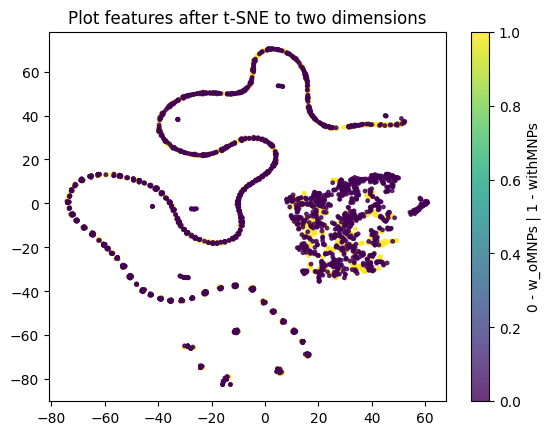

In [221]:
feature_arr_scaled = StandardScaler().fit_transform(arr_list)

tsne = TSNE(n_components=2, random_state=42)
feature_arr_tsne = tsne.fit_transform(feature_arr_scaled)
print(feature_arr_tsne)

x1 = []
y1 = []
colors1 = []
x1_clean = []
y1_clean = []
colors_clean = []
for i in range(len(feature_arr_tsne)):
    item_x, item_y = feature_arr_tsne[i]
    item_color = tag_list[i]
    x1.append(item_x)
    y1.append(item_y)
    colors1.append(item_color)

# Create a scatter plot for PCA
plt.scatter(x1, y1, c=colors1, cmap='viridis', s=6, alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('0 - w_oMNPs | 1 - withMNPs')
# Set plot title and labels
plt.title('Plot features after t-SNE to two dimensions')
# Display the plot
plt.show()


Dimension redunction to 2D using PCA

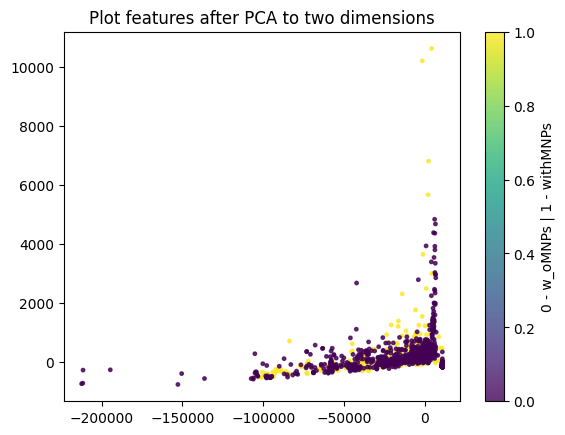

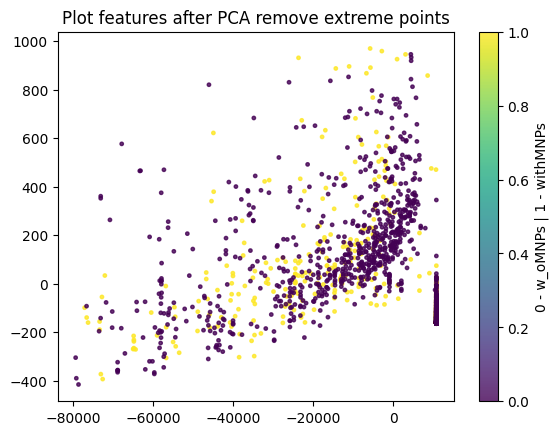

In [228]:
pca = PCA(n_components=2)
pca.fit(arr_list)
arr_list_after_pca = pca.transform(arr_list)

x = []
y = []
colors = []
x_clean = []
y_clean = []
colors_clean = []
for i in range(len(arr_list_after_pca)):
    item_x, item_y = arr_list_after_pca[i]
    item_color = tag_list[i]
    x.append(item_x)
    y.append(item_y)
    colors.append(item_color)
    if item_x < -80000 or item_y > 1000:
        continue
    x_clean.append(item_x)
    y_clean.append(item_y)
    colors_clean.append(item_color)
 
# Create a scatter plot for PCA
plt.scatter(x, y, c=colors, cmap='viridis', s=6, alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('0 - w_oMNPs | 1 - withMNPs')
# Set plot title and labels
plt.title('Plot features after PCA to two dimensions')
# Display the plot
plt.show()

# Create a scatter plot for PCA with removing ends (for visual only!)
plt.scatter(x_clean, y_clean, c=colors_clean, cmap='viridis', s=6, alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('0 - w_oMNPs | 1 - withMNPs')
# Set plot title and labels
plt.title('Plot features after PCA remove extreme points')
# Display the plot
plt.show()

# Run models after PCA to 2
It seems that the PCA has better division of the data to recordings with MNPs and without MNPs than the t-SNE

In [229]:
# Splitting the features (X) and results (y) for train and validation.
# We determine the seed to be 42 and the validation to be 0.25 of all the original training data.
X_pca = arr_list_after_pca
y_pca = tag_list
X_train_pca, X_validation_pca, y_train_pca, y_validation_pca = train_test_split(X_pca, y_pca, test_size=0.25, random_state=42) 

# for cross validation we will use 10 splits
kf = 10

Accuracy of model on validation set: 0.5801713586291309
Accuracy of model on training set: 0.6527947776417788
Confusion matrix on validation set:
[[354  94]
 [249 120]]
classification report :
              precision    recall  f1-score   support

           0       0.59      0.79      0.67       448
           1       0.56      0.33      0.41       369

    accuracy                           0.58       817
   macro avg       0.57      0.56      0.54       817
weighted avg       0.58      0.58      0.56       817

AUC: 0.6364117547425474


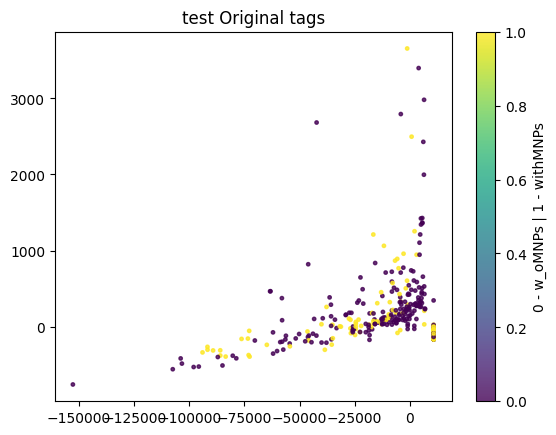

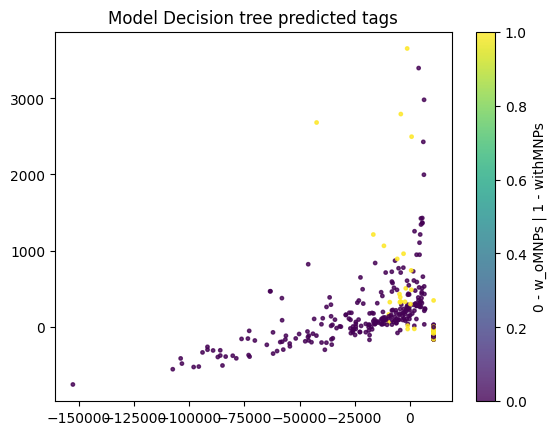

In [230]:
clf_dt_pca = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=8,
                              min_samples_split=10, min_samples_leaf=5, random_state=42) 

clf_dt_pca = clf_dt_pca.fit(X_train_pca,y_train_pca)
y_pred_dt_pca = clf_dt_pca.predict(X_validation_pca)

print_accuracy_results(X_train_pca, y_train_pca, X_validation_pca, y_validation_pca, y_pred_dt_pca, clf_dt_pca, is_pca=True, model_name="Decision tree") 

Accuracy of model on validation set: 0.5483476132190942
Accuracy of model on training set: 0.6062831497348021
Confusion matrix on validation set:
[[448   0]
 [369   0]]
classification report :
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       448
           1       0.00      0.00      0.00       369

    accuracy                           0.55       817
   macro avg       0.27      0.50      0.35       817
weighted avg       0.30      0.55      0.39       817



c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

AUC: 0.5018933894696089


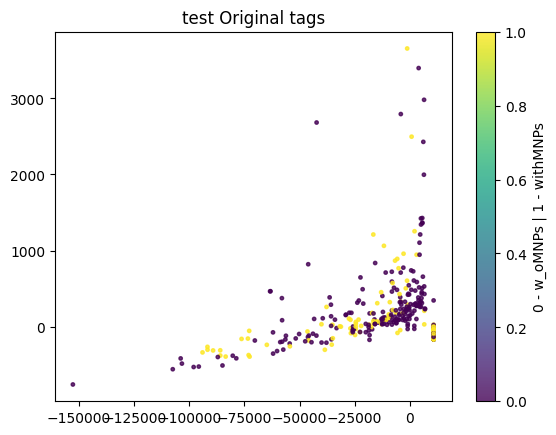

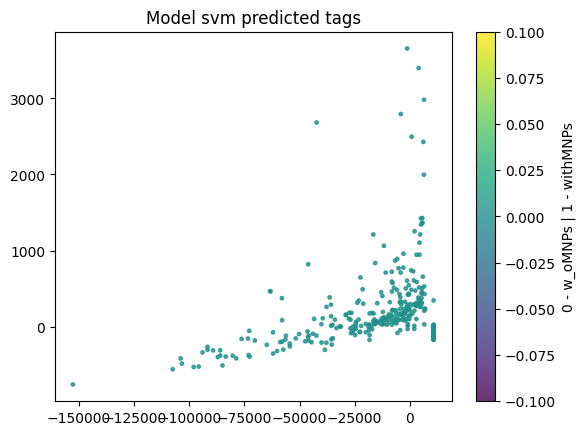

In [232]:
clf_svm_pca = svm.SVC(kernel='rbf', C=0.9, probability=True)
clf_svm_pca.fit(X_train_pca, y_train_pca)
y_pred_svm_pca = clf_svm_pca.predict(X_validation_pca)

print_accuracy_results(X_train_pca, y_train_pca, X_validation_pca, y_validation_pca, y_pred_svm_pca, clf_svm_pca, is_pca=True, model_name="svm") 

Accuracy of model on validation set: 0.5422276621787026
Accuracy of model on training set: 0.5940432476540187
Confusion matrix on validation set:
[[434  14]
 [360   9]]
classification report :
              precision    recall  f1-score   support

           0       0.55      0.97      0.70       448
           1       0.39      0.02      0.05       369

    accuracy                           0.54       817
   macro avg       0.47      0.50      0.37       817
weighted avg       0.48      0.54      0.40       817

AUC: 0.5319214576074333


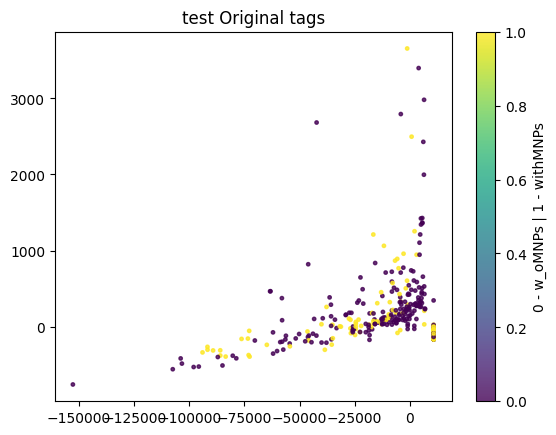

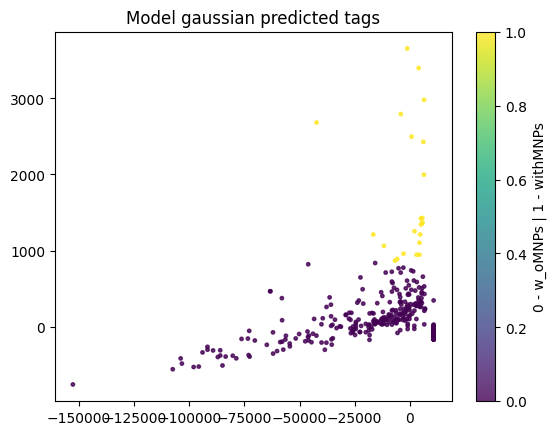

In [233]:
clf_nb_pca = GaussianNB()  # assuming the featers have normal gaussian distrubtion
clf_nb_pca.fit(X_train_pca, y_train_pca)
y_pred_nb_pca = clf_nb_pca.predict(X_validation_pca)

print_accuracy_results(X_train_pca, y_train_pca, X_validation_pca, y_validation_pca, y_pred_nb_pca, clf_nb_pca, is_pca=True, model_name="gaussian") 

parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy of model on validation set: 0.594859241126071
Accuracy of model on training set: 0.8217054263565892
Confusion matrix on validation set:
[[318 130]
 [201 168]]
classification report :
              precision    recall  f1-score   support

           0       0.61      0.71      0.66       448
           1       0.56      0.46      0.50       369

    accuracy                           0.59       817
   macro avg       0.59      0.58      0.58       817
weighted avg       0.59      0.59      0.59       817

AUC: 0.6409062862950057


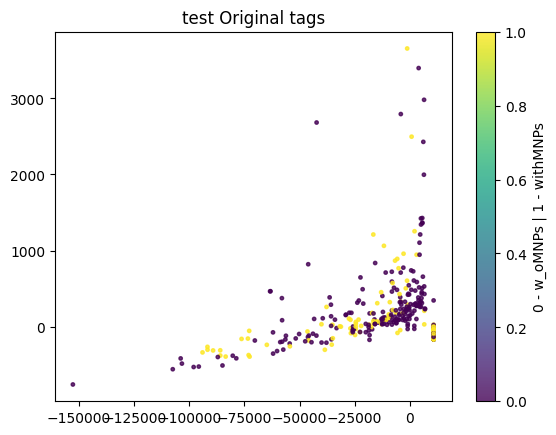

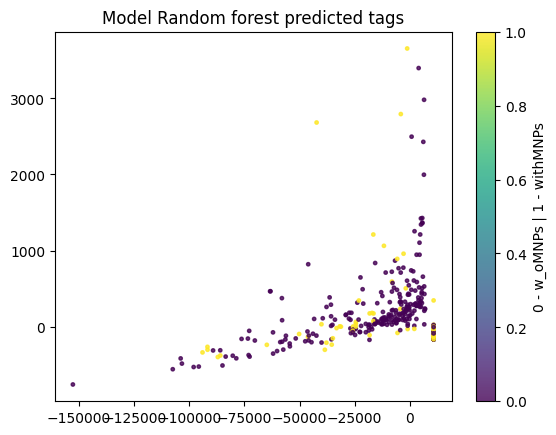

In [234]:
clf_rf_pca = RandomForestClassifier(random_state = 42)

clf_rf_pca.fit(X_train_pca, y_train_pca)
y_pred_rf_pca = clf_rf_pca.predict(X_validation_pca)

# Evaluate the accuracy on the validation set
print(f"parameters:")
print(clf_rf_pca.get_params())

print_accuracy_results(X_train_pca, y_train_pca, X_validation_pca, y_validation_pca, y_pred_rf_pca, clf_rf_pca, is_pca=True, model_name="Random forest") 

Accuracy of model on validation set: 0.5483476132190942
Accuracy of model on training set: 0.6062831497348021
Confusion matrix on validation set:
[[448   0]
 [369   0]]
classification report :
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       448
           1       0.00      0.00      0.00       369

    accuracy                           0.55       817
   macro avg       0.27      0.50      0.35       817
weighted avg       0.30      0.55      0.39       817

AUC: 0.5729227158343012


c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\7000028312\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

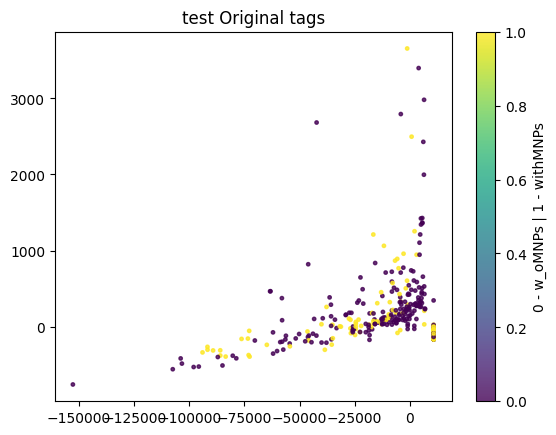

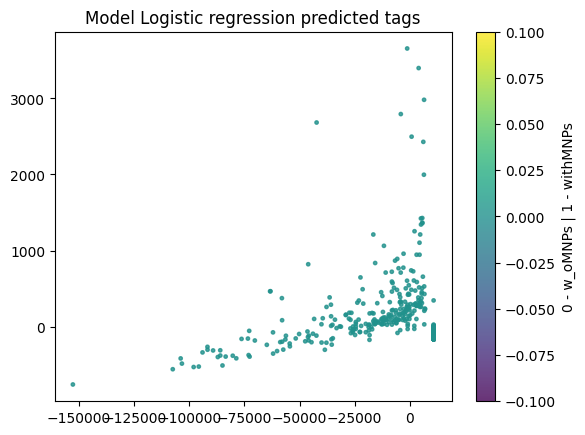

In [235]:
# Initialize the logistic regression model
clf_lr_pca = LogisticRegression(random_state=42, max_iter=1000)

# Fit the model on the training data
clf_lr_pca.fit(X_train_pca, y_train_pca)

# Predict on the validation set
y_pred_lr_pca = clf_lr_pca.predict(X_validation_pca)

print_accuracy_results(X_train_pca, y_train_pca, X_validation_pca, y_validation_pca, y_pred_lr_pca, clf_lr_pca, is_pca=True, model_name="Logistic regression") 